# Prep run

In [8]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cart
import pyresample
import warnings
warnings.filterwarnings('ignore')

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [9]:

def get_aste_vector(U,V,nfx,nfy,sign_switch):
    '''
    inputs:
        U: in compact form
        V: in compact form
        nfx: x-size of ASTE faces
        nfy: y-size of ASTE faces
        sign_switch: boolean, TF
    outputs:
        uaste, vaste: the tracer form of the u and v arrays of size 541,901
    '''
    # take care of 2D if needed
    if len(U.shape)<3:
        U = U[np.newaxis,:,:]
    if len(V.shape)<3:
        V = V[np.newaxis,:,:]
    
    # set up the size
    nz,ny,nx = U.shape[0],U.shape[1],U.shape[2]   #print(nz,ny,nx)
    #print(nz,ny,nx)
    
    # order stored in compact format
    nfx1 = nfx.copy()
    nfy1 = nfy.copy()

    # try to put all on one big matrix - we skip edge cases for now
    Unew = np.full((nz,nfy[0] + nfx[2] + nfx[3],nfy[4] + nfx[0]),np.nan)           # nz, 900, 540
    Vnew = np.full((nz, nfy[0] + nfx[2] + nfx[3],nfy[4] + nfx[0]), np.nan)

    # face1
    tmpU=U[:,0:nfy[0],0:nx]               #(nz,450,270)
    tmpV=V[:,0:nfy[0],0:nx]               #(nz,450,270)
    Unew[:,0:nfy[0],nx:2*nx]=tmpU
    Vnew[:,0:nfy[0],nx:2*nx]=tmpV

    # face 3 - rotate 180 degrees
    # -u -> new_u, -v -> new_v
    tmpU=U[:,nfy[0]:nfy[0]+nx,0:nx]         #(nz, 270,270)
    tmpU=np.transpose(tmpU, (1,2,0))        #(270,270,nz)
    tmpU=list(zip(*tmpU[::-1]))
    tmpU=np.transpose(tmpU,[2,0,1])         #(nz,270,270)

    tmpV=V[:,nfy[0]:nfy[0]+nx,0:nx]         #(nz, 270,270)
    tmpV=np.transpose(tmpV, (1,2,0))        #(270,270,nz)
    tmpV=list(zip(*tmpV[::-1]))
    tmpV=np.transpose(tmpV,[2,0,1])         #(nz,270,270)

    Unew[:,nfy[0]:nfy[0]+nx,nx:2*nx] = -tmpV
    Vnew[:,nfy[0]:nfy[0]+nx,nx:2*nx] = tmpU

    # swtich sign if needed
    if sign_switch:
        Unew = np.abs(Unew)
        Vnew = np.abs(Vnew)

    # we still need to shift to add the padding in U
    up = Unew.copy()                                                # (nz,900,540)
    sz = up.shape
    #print(sz)
    new_shape = (sz[0], sz[1]+1, sz[2] + 1)
    uq = np.full(new_shape, np.nan)                                 # (nz,901,541)
    
    # keep everything in y-dir from 1-450 (top of face 3), ix goes from 1-540, keep 541 as nan
    uq[:,:nfy[0],:nx*2] = up[:,:nfy[0],:nx*2]
    #for y-dir 450, what was called ix=1 should now be reassigned ix=2, shift everything 1 grid to the right
    uq[:,nfy[0]:sz[1],1:nx*2+1] = up[:,nfy[0]:sz[1],:nx*2]

    # now we can add the padding in V
    vp = Vnew.copy()
    vq = np.full(new_shape, np.nan)                                 # (nz,901,541)

    # keep everything from ix=271:540, ignore 901
    vq[:,:nfy[0]+nfx[2]+nfx[3],nx:2*nx] = vp[:,:nfy[0]+nfx[2]+nfx[3],nx:2*nx]
    # shift everything from ix=1:270 1 grid up
    vq[:,1:sz[1]+1,:nx] = vp[:,:sz[1],:nx]

    # reset original arrays after padding
    Unew = uq
    Vnew = vq

    return Unew,Vnew

In [10]:
# define basin we want - here 6 is for Barents
# we can look directly at the layers output if we want to:
#  cd /scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/
iB = 6   # see mskBasin if you want for later; maybe we should write this to file

In [11]:
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [12]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirrun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirIn = dirrun + "diags/BUDG/"
dirDiags = dirrun + "diags/"
dirState = dirDiags + "STATE/"
dirGrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"
dirtrsp = dirDiags + "TRSP/"

bigaste = True

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

# save myParms from An hard-coding
save_budg_3d = 0
save_budg_2d = 1
save_budg_scalar = 0
save_budg_lev = 0

strbudg = 'Mass'
kBudget = 1
test3d = True
plot_fig = 1
# kz = [[1, 5], [6, 10], [11, 19], [20, 23]]

myparms = {
    'yearFirst': 1979,
    'yearLast': 1979,
    'yearInAv': [1979, 1979],
    'timeStep': 3600,
    'iceModel': 1,
    'useRFWF': 1,
    'useNLFS': 4,
    'rStar': 2,
    'rhoconst': 1029,
    'rcp': 1029 * 3994,    # reference seawater specific heat capacity (1029 kg/m^3) * (3994 J/kg K) = J/(m^3*degC)
    'rhoi': 910,
    'rhosn': 330,
    'flami': 334000,
    'flamb': 2500000,
    'SIsal0': 4,
    'diagsAreMonthly': 0,
    'diagsAreAnnual': 0,
    'recInAve': [1, 2],
    'SaltPlumeHeatFlux': 0,  # Not sure what this is
    'conserveTr': 0
}

deltaTime = myparms['timeStep']
dt = 86400

# get time-steps:
flist = [f for f in os.listdir(dirIn) if f.startswith('budg2d_snap_set1.') and f.endswith('.data')]
idot = flist[0].index('.')
idot = [idot+1, flist[0][idot+1:].index('.')+idot+1]
idot = np.asarray(idot,dtype=int)

mygrid = {
    'dirGrid': dirGrid,
    'nFaces': 1,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','XG','YG','RAC','Depth','DXG','DYG','DXC','DYC']
fldstr3d = ['hFacC','hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC','hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','RF','DRC','DRF']

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirGrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirGrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirGrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

mygrid['mskC'][mygrid['mskC'] == 0] = np.nan

areaW, areaS, Vol = [], [], []
for k in range(nz):
    areaW.append(mygrid['DYG'] * mygrid['DRF'][k])
    areaS.append(mygrid['DXG'] * mygrid['DRF'][k])
    Vol.append(mygrid['RAC'] * mygrid['DRF'][k])

# block out obcs
# np tile I think operates the same as repmat in MATLAB
RAC = mygrid['RAC']
RAC3 = np.tile(RAC,(nz,1,1))

hfC = mygrid['hFacC']
DD = mygrid['Depth']
dxg = mygrid['DXG']
dyg = mygrid['DYG']
dxg3d = np.tile(dxg,(nz,1,1))
dyg3d = np.tile(dyg,(nz,1,1))

print(mygrid['DRF'].shape,np.zeros((nz, ny, nx)).shape)
drf3d = mk3D_mod(mygrid['DRF'], np.zeros((nz, ny, nx)))
DD3d = mk3D_mod(DD,np.zeros((nz, ny, nx)))

hfC[hfC == 0] = np.nan
hfC1 = hfC[0, :, :]
hfC1[hfC1 == 0] = np.nan

RACg = RAC * hfC1
hfC1p = np.copy(hfC1)

hfC1p[:, nx-1] = np.nan
hfC1p[ny-1,:] = np.nan
RACgp = RAC * hfC1p

# mygrid['hFacC'][mygrid['hFacC'] > 0] = 1  # test
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)
# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

# copy basin listing from lookat_layers
fileprefix = "/scratch/pillarh/aste_270x450x180/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v3_osnap.mat"
if nx == 270:
    inf = loadmat(filename)
    mskBasin = (inf["mskBasin"])

mskBasin = mskBasin.T               # python adjustment

# this is now different syntax than the other file
strb=np.array(['CanadaB','ChukchiS','MakarovB','AmundsenB','NansenB','BeringS','BarentsS','GINs','CAA',
               'SPG','LabSea','NPac','NAtlantic','AtlS30'])

mskBasin[mskBasin==50] =6
mskBasin[mskBasin==200]=7
mskBasin[mskBasin==300]=8
mskBasin[mskBasin==400]=9
mskBasin[mskBasin==500]=9
mskBasin[mskBasin==600]=10
mskBasin[mskBasin==700]=11
mskBasin[mskBasin==-1]=12
mskBasin[mskBasin==-100]=13
latNA = 30
lonNA = -82
condition_13 = (mskBasin == 0) & (mygrid['YC'] > latNA) & (mygrid['XC'] > lonNA) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_13] = 13
condition_14 = (mskBasin == 0) & (hf1.reshape((ny,nx)) > 0)
mskBasin[condition_14] = 14

mskBasin = mskBasin * hf1
mskBasin = mskBasin[0,:,:]   # change indexing for  python
mskBasin -= 1

# create mskBasin3D to also add to the dataset
mskBasin3D = np.tile(mskBasin[np.newaxis,:,:],(nz,1,1))

# write the wet mask and also set to nan
wetmask = mygrid['hFacC']
print(wetmask.shape)
wetmask_tracer = get_aste_tracer(wetmask,nfx,nfy)
print("hey",wetmask_tracer.shape)
wetmask_tracer[:,450:,:270] = np.nan
wetmask = aste_tracer2compact(wetmask_tracer,nfx,nfy)
print(wetmask.shape)

dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsBasin = {'title' : 'CanadaB: 0, ChukchiS: 1, MakarovB: 2, AmundsenB: 3, NansenB: 4, BeringS: 5, BarentsS: 6, GINs: 7, CAA: 8, SPG: 9, LabSea: 10, NPac: 11, NAtlantic: 12, AtlS30: 13',
              'standard_name' : 'Basins labeled',
             'units' : 'degree_c'}

attrsWet= {'title' : 'model wet points in compact form',
         'standard_name' : '1= wet, 0=dry',
         'units' : 'boolean'}

# add mskBasin and wetmask to the xarray for the dataset
mskBasin_3D = xr.DataArray(data = mskBasin*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsBasin)

mskBasin_2D = xr.DataArray(data = mskBasin*wetmask[0,:,:],
                    dims = dims[1:],
                    coords = [coords["compact_x"],coords["compact_y"]],
                    attrs = attrsBasin)

wetmask_xr = xr.DataArray(data = wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsWet)


ds = xr.Dataset()
ds['mskBasin_3D'] = mskBasin_3D
ds['mskBasin_2D'] = mskBasin_2D
ds['wetmask'] = wetmask_xr

# get the number of points in the basin and we can use this as a mask for later
mymsk = mskBasin.copy()
mymsk[mymsk != iB] = np.nan
npoints = len(np.where(mymsk == iB)[0])   # set number of points in the basin to be used later
print(npoints)

DRF3d = mk3D_mod(mygrid["DRF"],np.zeros((nz, ny, nx)))

(50,) (50, 1350, 270)
hf1 (1350, 270)
shape of tracer fld: (1, 900, 540)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270)
hey (50, 900, 540)
shape of tracer fld: (50, 900, 540)
(50, 1350, 270)
compact shape (50, 1350, 270)
(50, 1350, 270)
10650


In [13]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt = 600 # for the MODEL, not for tendency calculations
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt,startyr,endyr)

times = {}
times["2014"] = np.array([3,4,9,10])
# times["2015"] = np.array([1])

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt,startyr,1,1)

# ocean and ice
AB_gT=0
AB_gS=0
debug = False
ffac = 1

dt1 = datetimes[1]-datetimes[0]   # days
dt2 = datetimes[3]-datetimes[2]   # days
dt1 = dt1.total_seconds()
dt2 = dt2.total_seconds()
print(dt1,dt2)

2678400.0 2592000.0


# Read files and make dataframe
- UVEL, VVEL for vorticity vectors, EXF for wind forcing
- ADV and DF terms
- T and S fields

In [14]:
# read timesteps at index 1 and 3
meta_budg3d_hflux_set2= parsemeta(dirIn + "budg3d_hflux_set2" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_budg3d_hflux_set2['fldList'])
varnames = np.array(['UVELMASS','VVELMASS','ADVx_TH','ADVy_TH','DFxE_TH','DFyE_TH','ADVx_SLT','ADVy_SLT','DFxE_SLT','DFyE_SLT'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[0])       # m/s
VVELMASS,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[1])       # m/s
ADVx_TH,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[2])       # m/s
ADVy_TH,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[3])       # m/s
DFxE_TH,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[4])       # m/s
DFyE_TH,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[5])       # m/s
ADVx_SLT,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[6])       # m/s
ADVy_SLT,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[7])       # m/s
DFxE_SLT,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[8])       # m/s
DFyE_SLT,its,meta = rdmds(dirIn + "budg3d_hflux_set2", int(tsstr[1]),returnmeta=True,rec = recs[9])       # m/s

# reshaping and fixing up
UVELMASS = UVELMASS.reshape(nz,ny,nx)
VVELMASS = VVELMASS.reshape(nz,ny,nx)
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)
DFxE_TH = DFxE_TH.reshape(nz,ny,nx)
DFyE_TH = DFyE_TH.reshape(nz,ny,nx)
ADVx_SLT = ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT = ADVy_SLT.reshape(nz,ny,nx)
DFxE_SLT = DFxE_SLT.reshape(nz,ny,nx)
DFyE_SLT = DFyE_SLT.reshape(nz,ny,nx)

In [122]:
# for heat tendency (J/s) - time not yet included here
# read the fldList
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR","SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
    
t1 = tsstr[1]
read = [int(t1)]

# make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
THETADR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
SALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m

THETADR = np.reshape(THETADR,(nz,ny,nx))
SALTDR = np.reshape(SALTDR,(nz,ny,nx))
theta = THETADR/DRF3d/mygrid['hFacC']
salt = SALTDR/DRF3d/mygrid['hFacC']

In [123]:
# load the EXF data from BUDG/exf_zflux_set1
# |EXFtaux |  1 |       |UM      U1|N/m^2           |zonal surface wind stress, >0 increases uVel
meta_exf_zflux_set1= parsemeta(dirIn + "exf_zflux_set1" + '.' + tsstr[1] + '.meta')
fldlist = np.array(meta_exf_zflux_set1['fldList'])
# print(fldlist)   # can just start with the quivers of u and v 10m wind
varnames = np.array(['EXFuwind','EXFvwind'])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
EXFuwind,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[0])
EXFvwind,its,meta = rdmds(dirIn + "exf_zflux_set1", int(tsstr[1]),returnmeta=True,rec = recs[1])

EXFuwind = np.reshape(EXFuwind,(ny,nx))
EXFvwind = np.reshape(EXFvwind,(ny,nx))

In [124]:
# get the vectors of u and v without mass weighting
tmpUo,tmpVo = get_aste_vector(UVELMASS,VVELMASS,nfx,nfy,False)
tmpUo,tmpVo = tmpUo[:,:-1,:-1],tmpVo[:,:-1,:-1]

exfU,exfV = get_aste_vector(EXFuwind,EXFvwind,nfx,nfy,False)
exfU,exfV = exfU[:,:-1,:-1],exfV[:,:-1,:-1]

# Plot some vectors

In [125]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')

In [126]:
landmsk = np.full(mygrid['hFacC'].shape, np.nan)
landmsk[np.isnan(mygrid['hFacC'])] = 1
landmsk[~np.isnan(mygrid['hFacC'])] = np.nan
landmsk = get_aste_tracer(landmsk,nfx,nfy)[0]

In [127]:
# plt.quiver(X, Y, u, v, color='r', scale=1, width=0.005)
x = np.arange(0,540,1)
y = np.arange(0,900,1)
X, Y = np.meshgrid(x, y)

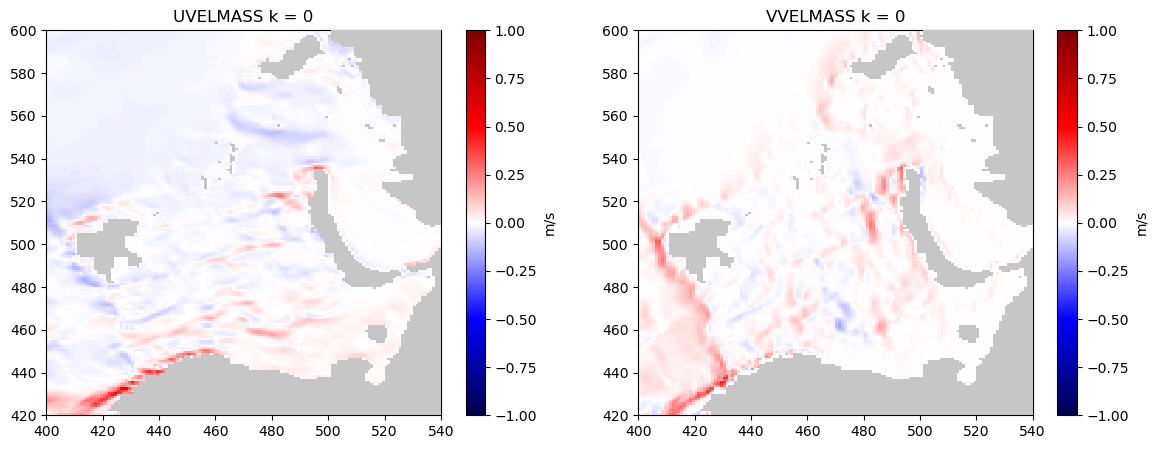

In [128]:
fig = plt.figure(figsize=(14,5))
ax = plt.subplot(121)
cb = ax.pcolormesh(tmpUo[0],cmap = 'seismic',vmin=-1,vmax=1)  # uvelmass
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
# plt.quiver(X, Y, tmpUo[0], tmpVo[0], color='r', scale=1, width=0.005)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("UVELMASS k = 0")
plt.colorbar(cb,label="m/s")

ax = plt.subplot(122)
cb = ax.pcolormesh(tmpVo[5],cmap = 'seismic',vmin=-1,vmax=1)  # vvelmass
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.set_xlim(400,540)
ax.set_ylim(420,600)
ax.set_title("VVELMASS k = 0")
plt.colorbar(cb,label="m/s")

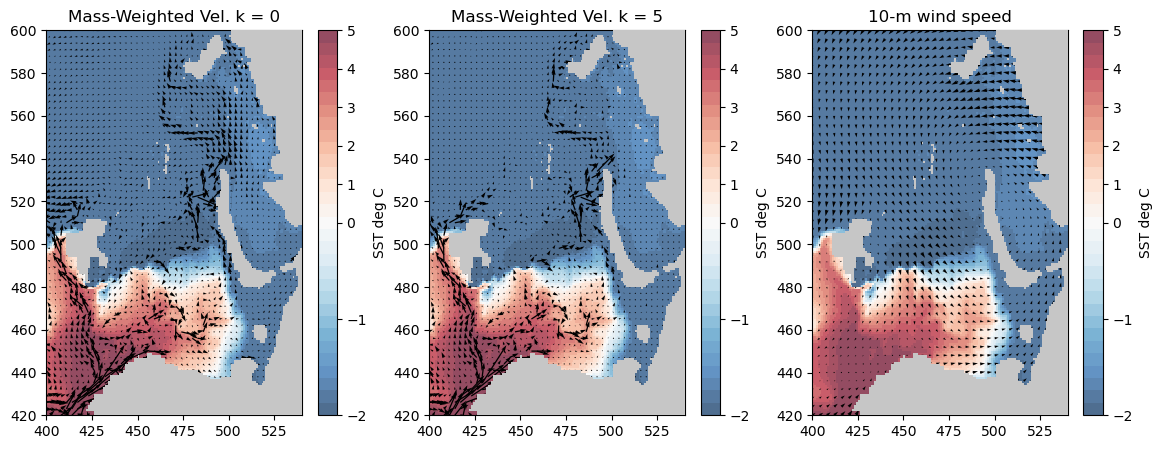

In [129]:
# make a meshgrid t
step = 3
norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=5)

fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(theta,nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.quiver(X[::step,::step], Y[::step,::step], tmpUo[0][::step,::step], tmpVo[0][::step,::step],scale=3,width=0.005)
ax.set_title("Mass-Weighted Vel. k = 0")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(theta,nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.quiver(X[::step,::step], Y[::step,::step], tmpUo[5][::step,::step], tmpVo[5][::step,::step],scale=3,width=0.005)
ax.set_title("Mass-Weighted Vel. k = 5")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer(theta,nfx,nfy)[0],cmap=cmap,norm=norm,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
ax.quiver(X[::step,::step], Y[::step,::step], exfU[0][::step,::step], exfV[0][::step,::step],scale=200,width=0.005)
ax.set_title("10-m wind speed")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

plt.savefig(path + "vel_wind_overSST.png",dpi=300)

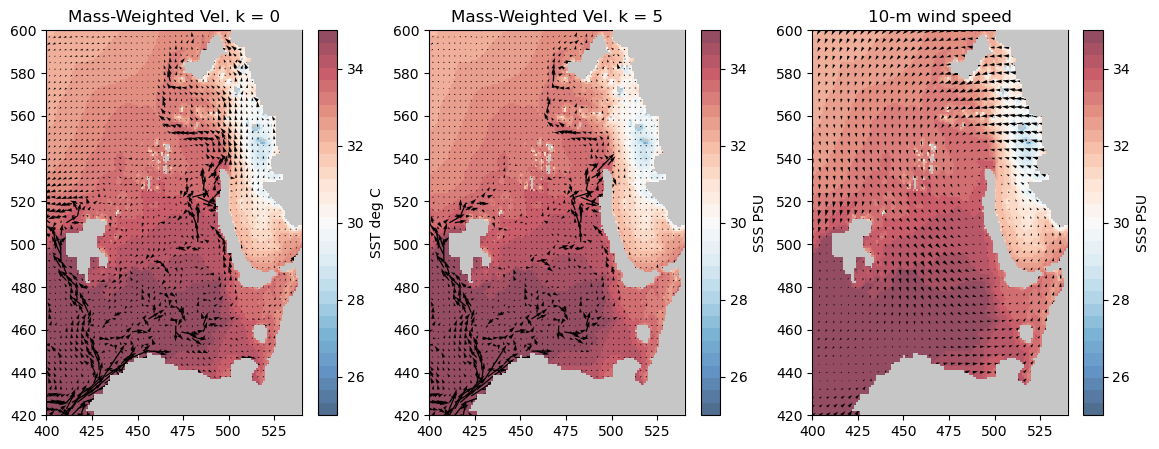

In [130]:
# make a meshgrid t
step = 3
# norm = TwoSlopeNorm(vmin=-2,vcenter=0,vmax=5)

fig = plt.figure(figsize=(14,5))
ax = plt.subplot(131)
cb = ax.pcolormesh(get_aste_tracer(salt,nfx,nfy)[0],cmap=cmap,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.quiver(X[::step,::step], Y[::step,::step], tmpUo[0][::step,::step], tmpVo[0][::step,::step],scale=3,width=0.005)
ax.set_title("Mass-Weighted Vel. k = 0")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SST deg C")

ax = plt.subplot(132)
cb = ax.pcolormesh(get_aste_tracer(salt,nfx,nfy)[0],cmap=cmap,vmin=25,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
ax.quiver(X[::step,::step], Y[::step,::step], tmpUo[5][::step,::step], tmpVo[5][::step,::step],scale=3,width=0.005)
ax.set_title("Mass-Weighted Vel. k = 5")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

ax = plt.subplot(133)
cb = ax.pcolormesh(get_aste_tracer(salt,nfx,nfy)[0],cmap=cmap,vmin=29,vmax=35,alpha=0.7)
ax.pcolormesh(landmsk,cmap="Greys",vmin=.9,vmax=1.2,zorder=5)
step = 4
ax.quiver(X[::step,::step], Y[::step,::step], exfU[0][::step,::step], exfV[0][::step,::step],scale=200,width=0.005)
ax.set_title("10-m wind speed")
ax.set_xlim(400,540)
ax.set_ylim(420,600)
plt.colorbar(cb,label="SSS PSU")

plt.savefig(path + "vel_wind_oversalt.png",dpi=300)